In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
class DNASequenceClassifier:
    def __init__(self, sequence_length=200, num_classes=2):
        self.sequence_length = sequence_length
        self.num_classes = num_classes
        self.model = None
        self.history = None

    def one_hot_encode(self, sequences):
        mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3}
        encoded = np.zeros((len(sequences), self.sequence_length, 4))

        for i, seq in enumerate(sequences):
            for j, nucleotide in enumerate(seq[:self.sequence_length]):
                if nucleotide in mapping:
                    encoded[i, j, mapping[nucleotide]] = 1
        return encoded

    def attention_layer(self, inputs, name="attention"):
        attention_weights = layers.Dense(1, activation='tanh', name=f"{name}_weights")(inputs)
        attention_weights = layers.Flatten()(attention_weights)
        attention_weights = layers.Activation('softmax', name=f"{name}_softmax")(attention_weights)
        attention_weights = layers.RepeatVector(inputs.shape[-1])(attention_weights)
        attention_weights = layers.Permute([2, 1])(attention_weights)

        attended = layers.Multiply(name=f"{name}_multiply")([inputs, attention_weights])
        return layers.GlobalMaxPooling1D()(attended)

    def build_model(self):
        inputs = layers.Input(shape=(self.sequence_length, 4), name="dna_input")

        conv_layers = []
        filter_sizes = [3, 7, 15, 25]

        for i, filter_size in enumerate(filter_sizes):
            conv = layers.Conv1D(
                filters=64,
                kernel_size=filter_size,
                activation='relu',
                padding='same',
                name=f"conv_{filter_size}"
            )(inputs)
            conv = layers.BatchNormalization(name=f"bn_conv_{filter_size}")(conv)
            conv = layers.Dropout(0.2, name=f"dropout_conv_{filter_size}")(conv)

            attended = self.attention_layer(conv, name=f"attention_{filter_size}")
            conv_layers.append(attended)

        if len(conv_layers) > 1:
            merged = layers.Concatenate(name="concat_multiscale")(conv_layers)
        else:
            merged = conv_layers[0]

        dense = layers.Dense(256, activation='relu', name="dense_1")(merged)
        dense = layers.BatchNormalization(name="bn_dense_1")(dense)
        dense = layers.Dropout(0.5, name="dropout_dense_1")(dense)

        dense = layers.Dense(128, activation='relu', name="dense_2")(dense)
        dense = layers.BatchNormalization(name="bn_dense_2")(dense)
        dense = layers.Dropout(0.3, name="dropout_dense_2")(dense)

        if self.num_classes == 2:
            outputs = layers.Dense(1, activation='sigmoid', name="output")(dense)
            loss = 'binary_crossentropy'
            metrics = ['accuracy', 'precision', 'recall']
        else:
            outputs = layers.Dense(self.num_classes, activation='softmax', name="output")(dense)
            loss = 'categorical_crossentropy'
            metrics = ['accuracy']

        self.model = keras.Model(inputs=inputs, outputs=outputs, name="DNA_CNN_Classifier")

        optimizer = keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        )

        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=metrics
        )

        return self.model

    def generate_synthetic_data(self, n_samples=10000):
        sequences = []
        labels = []

        positive_motifs = ['TATAAA', 'CAAT', 'GGGCGG', 'TTGACA']
        negative_motifs = ['AAAAAAA', 'TTTTTTT', 'CCCCCCC', 'GGGGGGG']

        nucleotides = ['A', 'T', 'G', 'C']

        for i in range(n_samples):
            sequence = ''.join(random.choices(nucleotides, k=self.sequence_length))

            if i < n_samples // 2:
                motif = random.choice(positive_motifs)
                pos = random.randint(0, self.sequence_length - len(motif))
                sequence = sequence[:pos] + motif + sequence[pos + len(motif):]
                label = 1
            else:
                if random.random() < 0.3:
                    motif = random.choice(negative_motifs)
                    pos = random.randint(0, self.sequence_length - len(motif))
                    sequence = sequence[:pos] + motif + sequence[pos + len(motif):]
                label = 0

            sequences.append(sequence)
            labels.append(label)

        return sequences, np.array(labels)

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]

        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate_and_visualize(self, X_test, y_test):
        y_pred_proba = self.model.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0,0].plot(self.history.history['loss'], label='Training Loss')
        axes[0,0].plot(self.history.history['val_loss'], label='Validation Loss')
        axes[0,0].set_title('Training History - Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()

        axes[0,1].plot(self.history.history['accuracy'], label='Training Accuracy')
        axes[0,1].plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        axes[0,1].set_title('Training History - Accuracy')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues')
        axes[1,0].set_title('Confusion Matrix')
        axes[1,0].set_ylabel('Actual')
        axes[1,0].set_xlabel('Predicted')

        axes[1,1].hist(y_pred_proba[y_test==0], bins=50, alpha=0.7, label='Negative', density=True)
        axes[1,1].hist(y_pred_proba[y_test==1], bins=50, alpha=0.7, label='Positive', density=True)
        axes[1,1].set_title('Prediction Score Distribution')
        axes[1,1].set_xlabel('Prediction Score')
        axes[1,1].set_ylabel('Density')
        axes[1,1].legend()

        plt.tight_layout()
        plt.show()

        return y_pred, y_pred_proba

🧬 Advanced DNA Sequence Classification with CNN
Generating synthetic DNA sequences...
Encoding DNA sequences...
Training set: (6400, 200, 4)
Validation set: (1600, 200, 4)
Test set: (2000, 200, 4)
Building CNN model...


Model: "DNA_CNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dna_input           │ (None, 200, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv1D)     │ (None, 200, 64)   │        832 │ dna_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_7 (Conv1D)     │ (None, 200, 64)   │      1,856 │ dna_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_15 (Conv1D)    │ (None, 200, 64)   │      3,904 │ dna_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_25 (Conv1D)    │ (None, 200, 64)   │      6,464 │ dna_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_3           │ (None, 200, 64)   │        256 │ conv_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_7           │ (None, 200, 64)   │        256 │ conv_7[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_15          │ (None, 200, 64)   │        256 │ conv_15[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv_25          │ (None, 200, 64)   │        256 │ conv_25[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_conv_3      │ (None, 200, 64)   │          0 │ bn_conv_3[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_conv_7      │ (None, 200, 64)   │          0 │ bn_conv_7[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_conv_15     │ (None, 200, 64)   │          0 │ bn_conv_15[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_conv_25     │ (None, 200, 64)   │          0 │ bn_conv_25[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3_weights │ (None, 200, 1)    │         65 │ dropout_conv_3[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_7_weights │ (None, 200, 1)    │         65 │ dropout_conv_7[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_15_weigh… │ (None, 200, 1)    │         65 │ dropout_conv_15[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_25_weigh… │ (None, 200, 1)    │         65 │ dropout_conv_25[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 200)       │          0 │ attention_3_weig… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 114,693 (448.02 KB)

 Trainable params: 113,413 (443.02 KB)

 Non-trainable params: 1,280 (5.00 KB)

None
Training model...
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 166ms/step - accuracy: 0.4967 - loss: 0.9056 - precision: 0.5024 - recall: 0.4954 - val_accuracy: 0.5000 - val_loss: 0.6936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.5485 - loss: 0.7502 - precision: 0.5561 - recall: 0.5338 - val_accuracy: 0.5000 - val_loss: 0.6928 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.6071 - loss: 0.6833 - precision: 0.6167 - recall: 0.5898 - val_accuracy: 0.5000 - val_loss: 0.6930 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.6710 - loss: 0.6122 - precision: 0.6849 - recall: 0.6473 - val_accuracy: 0.5000 - val_loss: 0.7579 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.00

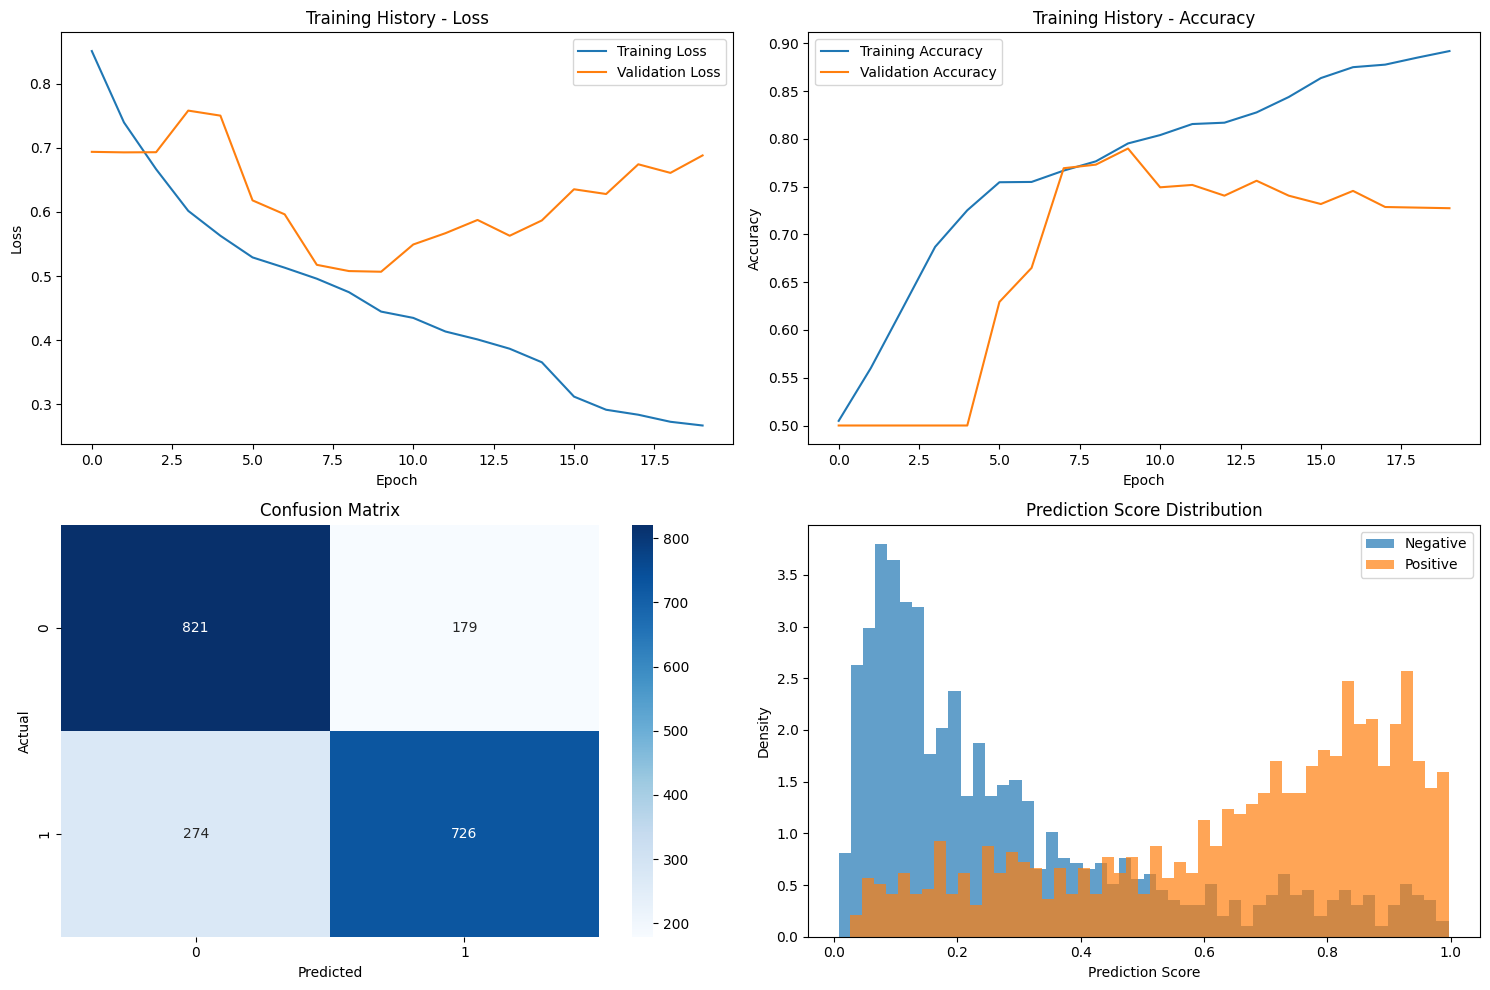

✅ Training and evaluation complete!


In [14]:
def main():
    print("🧬 Advanced DNA Sequence Classification with CNN")
    print("=" * 50)

    classifier = DNASequenceClassifier(sequence_length=200, num_classes=2)

    print("Generating synthetic DNA sequences...")
    sequences, labels = classifier.generate_synthetic_data(n_samples=10000)

    print("Encoding DNA sequences...")
    X = classifier.one_hot_encode(sequences)

    X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.2, random_state=42, stratify=labels
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")

    print("Building CNN model...")
    model = classifier.build_model()
    print(model.summary())

    print("Training model...")
    classifier.train(X_train, y_train, X_val, y_val, epochs=30, batch_size=64)

    print("Evaluating model...")
    y_pred, y_pred_proba = classifier.evaluate_and_visualize(X_test, y_test)

    print("✅ Training and evaluation complete!")

if __name__ == "__main__":
    main()